### Modelo básico. Decision Tree

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import SelectKBest, f_classif

In [29]:
df = pd.read_csv("../data/processed/processed_no_dummies.csv", index_col=0)

In [30]:
df.head(5)

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,...,key,popularity,explicit,version_type_encoded,decade,energy_danceability_valence,acoustic_intensity,popularity_energy_ratio,valence_energy_dif,decade_range
0,0gNNToCW3qjabgTyBSjt3H,!Que Vida! - Mono Version,['Love'],220560,11/1/66,1966,0.5250,0.600,0.540,0.00305,...,9,26,0,1,1960,0.177228,-6.196575,48.147257,0.007,50s-60s
1,0tMgFpOrXZR6irEOLNWwJL,"""40""",['U2'],157840,2/28/83,1983,0.2280,0.368,0.480,0.70700,...,8,21,0,1,1980,0.059704,-2.645940,43.749089,-0.142,70s-80s
2,2ZywW3VyVx6rrlrX75n3JB,"""40"" - Live",['U2'],226200,8/20/83,1983,0.0998,0.272,0.684,0.01450,...,8,41,0,0,1980,0.051907,-0.970854,59.940644,-0.405,70s-80s
3,6DdWA7D1o5TU2kXWyCLcch,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,8,37,0,2,1980,0.062680,-1.723275,67.888663,-0.235,70s-80s
4,3vMmwsAiLDCfyc1jl76lQE,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,8,35,0,2,1980,0.062680,-1.723275,64.219005,-0.235,70s-80s


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139848 entries, 0 to 169906
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           139848 non-null  object 
 1   name                         139848 non-null  object 
 2   artists                      139848 non-null  object 
 3   duration_ms                  139848 non-null  int64  
 4   release_date                 139848 non-null  object 
 5   year                         139848 non-null  int64  
 6   acousticness                 139848 non-null  float64
 7   danceability                 139848 non-null  float64
 8   energy                       139848 non-null  float64
 9   instrumentalness             139848 non-null  float64
 10  liveness                     139848 non-null  float64
 11  loudness                     139848 non-null  float64
 12  speechiness                  139848 non-null  float64
 13  temp

Comenzamos tomando la decisión de centrarnos en las décadas desde 1950 hasta la de 2010, ambas incluidas. Esta decisión se fundamenta en dos motivos principales:

- Motivo estadístico: El análisis descriptivo previo nos ha mostrado una descompensación de datos en función de las décadas. El periodo escogido sí tiene una representación equilibrada.
- Motivo de negocio: Si el objetivo es que personas de edad avanzada puedan escuchar canciones de ahora que suenan a décadas pasadas, esas en las que ellos eran más jóvenes y descubrían nueva música, contar con décadas anteriores a los 50 no tendría mucho sentido por el propio perfil (edad) de los usuarios.

In [32]:
#Incluimos solo canciones entre las décadas de 1950 y 2010
df = df[(df['decade'] >= 1950) & (df['decade'] < 2010)]

In [33]:
df.head(5)

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,...,key,popularity,explicit,version_type_encoded,decade,energy_danceability_valence,acoustic_intensity,popularity_energy_ratio,valence_energy_dif,decade_range
0,0gNNToCW3qjabgTyBSjt3H,!Que Vida! - Mono Version,['Love'],220560,11/1/66,1966,0.5250,0.600,0.540,0.00305,...,9,26,0,1,1960,0.177228,-6.196575,48.147257,0.007,50s-60s
1,0tMgFpOrXZR6irEOLNWwJL,"""40""",['U2'],157840,2/28/83,1983,0.2280,0.368,0.480,0.70700,...,8,21,0,1,1980,0.059704,-2.645940,43.749089,-0.142,70s-80s
2,2ZywW3VyVx6rrlrX75n3JB,"""40"" - Live",['U2'],226200,8/20/83,1983,0.0998,0.272,0.684,0.01450,...,8,41,0,0,1980,0.051907,-0.970854,59.940644,-0.405,70s-80s
3,6DdWA7D1o5TU2kXWyCLcch,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,8,37,0,2,1980,0.062680,-1.723275,67.888663,-0.235,70s-80s
4,3vMmwsAiLDCfyc1jl76lQE,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,8,35,0,2,1980,0.062680,-1.723275,64.219005,-0.235,70s-80s


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119948 entries, 0 to 169906
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           119948 non-null  object 
 1   name                         119948 non-null  object 
 2   artists                      119948 non-null  object 
 3   duration_ms                  119948 non-null  int64  
 4   release_date                 119948 non-null  object 
 5   year                         119948 non-null  int64  
 6   acousticness                 119948 non-null  float64
 7   danceability                 119948 non-null  float64
 8   energy                       119948 non-null  float64
 9   instrumentalness             119948 non-null  float64
 10  liveness                     119948 non-null  float64
 11  loudness                     119948 non-null  float64
 12  speechiness                  119948 non-null  float64
 13  temp

In [35]:
df.columns

Index(['id', 'name', 'artists', 'duration_ms', 'release_date', 'year',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
       'key', 'popularity', 'explicit', 'version_type_encoded', 'decade',
       'energy_danceability_valence', 'acoustic_intensity',
       'popularity_energy_ratio', 'valence_energy_dif', 'decade_range'],
      dtype='object')

## DecisionTreeClassifier

### Baseline: todas las variables

In [53]:
X = df[['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
       'key', 'popularity', 'explicit', 'version_type_encoded',
       'energy_danceability_valence', 'acoustic_intensity',
       'popularity_energy_ratio', 'valence_energy_dif']]
y = df['decade_range']

In [54]:
#Dividimos en conjuntos para entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [55]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(119948, 19)
(23989, 19)
(95959, 19)
(23989,)
(95959,)


In [56]:
model_1 = DecisionTreeClassifier(random_state=42)

In [57]:
#Entrenamiento
model_1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [58]:
#Evaluación

y_pred_1 = model_1.predict(X_test)
accuracy_1 = accuracy_score(y_test, y_pred_1)
precision_1 = precision_score(y_test, y_pred_1, average='macro')
recall_1 = recall_score(y_test, y_pred_1, average='macro')
f1_1 = f1_score(y_test, y_pred_1, average='macro')

In [59]:
print("Accuracy del modelo Decision Tree:", accuracy_1)
print("Precisión (Precision):", precision_1)
print("Sensibilidad (Recall):", recall_1)
print("F1-Score:", f1_1)

Accuracy del modelo Decision Tree: 0.6718077512270866
Precisión (Precision): 0.6727862540196158
Sensibilidad (Recall): 0.6718066887124444
F1-Score: 0.6722390328091975


### DecisionTree 2

In [42]:
X_2 = df[['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
       'key', 'popularity']]
y = df['decade_range']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, train_size=0.2, random_state=42)
model_2 = DecisionTreeClassifier(random_state=42)
model_2.fit(X_train, y_train)

print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(119948, 19)
(23989, 13)
(95959, 13)
(23989,)
(95959,)


In [44]:
y_pred_2 = model_2.predict(X_test)
accuracy_2 = accuracy_score(y_test, y_pred_2)
precision_2 = precision_score(y_test, y_pred_2, average='macro')
recall_2 = recall_score(y_test, y_pred_2, average='macro')
f1_2 = f1_score(y_test, y_pred_2, average='macro')

print("Accuracy del modelo Decision Tree 2:", accuracy_2)
print("Precisión (Precision):", precision_2)
print("Sensibilidad (Recall):", recall_2)
print("F1-Score:", f1_2)

Accuracy del modelo Decision Tree 2: 0.6668681416021426
Precisión (Precision): 0.6674637856824831
Sensibilidad (Recall): 0.6668678283622037
F1-Score: 0.6671116674185272


### DecisionTree 3

In [19]:
X_3 = df[['duration_ms', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'mode',
       'key', 'explicit', 'version_type_encoded',
       'energy_danceability_valence', 'acoustic_intensity',
       'popularity_energy_ratio', 'valence_energy_dif']]
y = df['decade_range']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y, train_size=0.2, random_state=42)
model_3 = DecisionTreeClassifier(random_state=42)
model_3.fit(X_train, y_train)

print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(119948, 19)
(23989, 13)
(95959, 13)
(23989,)
(95959,)


In [21]:
y_pred_3 = model_3.predict(X_test)
accuracy_3 = accuracy_score(y_test, y_pred_3)
precision_3 = precision_score(y_test, y_pred_3, average='macro')
recall_3 = recall_score(y_test, y_pred_3, average='macro')
f1_3 = f1_score(y_test, y_pred_3, average='macro')

print("Accuracy del modelo Decision Tree 2:", accuracy_3)
print("Precisión (Precision):", precision_3)
print("Sensibilidad (Recall):", recall_3)
print("F1-Score:", f1_3)

Accuracy del modelo Decision Tree 2: 0.6331037213810065
Precisión (Precision): 0.6339914442614859
Sensibilidad (Recall): 0.6331013237869797
F1-Score: 0.6335166650373082


### DecisionTree 4

In [22]:
X_4 = df[['duration_ms', 'acousticness',
       'energy_danceability_valence', 'acoustic_intensity',
       'popularity_energy_ratio', 'valence_energy_dif']]
y = df['decade_range']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_4, y, train_size=0.2, random_state=42)
model_4 = DecisionTreeClassifier(random_state=42)
model_4.fit(X_train, y_train)

print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(119948, 19)
(23989, 6)
(95959, 6)
(23989,)
(95959,)


In [24]:
y_pred_4 = model_4.predict(X_test)
accuracy_4 = accuracy_score(y_test, y_pred_4)
precision_4 = precision_score(y_test, y_pred_4, average='macro')
recall_4 = recall_score(y_test, y_pred_4, average='macro')
f1_4 = f1_score(y_test, y_pred_4, average='macro')

print("Accuracy del modelo Decision Tree 2:", accuracy_4)
print("Precisión (Precision):", precision_4)
print("Sensibilidad (Recall):", recall_4)
print("F1-Score:", f1_4)

Accuracy del modelo Decision Tree 2: 0.6313529736658364
Precisión (Precision): 0.6312013509711402
Sensibilidad (Recall): 0.6313503098821059
F1-Score: 0.6312738936886865


### DecisionTree 5: SelecKBest

In [25]:
X_5 = df[['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
       'key', 'popularity', 'explicit', 'version_type_encoded',
       'energy_danceability_valence', 'acoustic_intensity',
       'popularity_energy_ratio', 'valence_energy_dif']]
y = df['decade_range']

In [26]:
k_values = range(1, X_5.shape[1] + 1)

In [27]:
mean_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    
    model = DecisionTreeClassifier(random_state=0)
    scores = cross_val_score(model, X_selected, y, cv=3)
    
    mean_scores.append(scores.mean())

KeyboardInterrupt: 

In [ ]:
best_k = k_values[np.argmax(mean_scores)]
best_score = max(mean_scores)

In [ ]:
print(f"El mejor valor de k es: {best_k} con un rendimiento promedio de: {best_score:.4f}")

El mejor valor de k es: 1 con un rendimiento promedio de: 0.6895


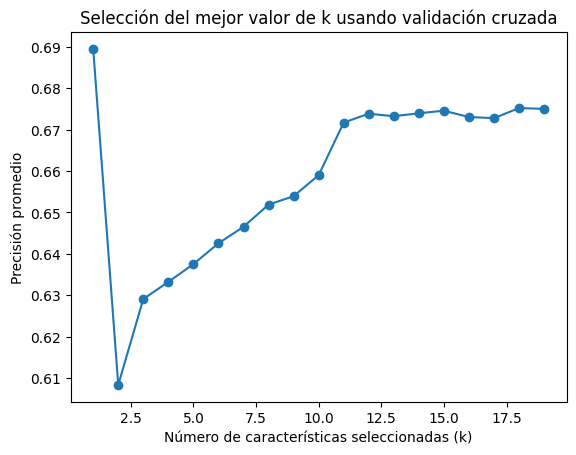

In [ ]:
plt.plot(k_values, mean_scores, marker='o')
plt.xlabel('Número de características seleccionadas (k)')
plt.ylabel('Precisión promedio')
plt.title('Selección del mejor valor de k usando validación cruzada')
plt.show()

In [ ]:
k = 13
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X_5, y)
selected_features = X_5.columns[selector.get_support()]

In [ ]:
print(f"\nCaracterísticas seleccionadas con SelectKBest (top {k}):")
print(selected_features)


Características seleccionadas con SelectKBest (top 13):
Index(['duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'loudness', 'tempo', 'valence', 'popularity',
       'explicit', 'energy_danceability_valence', 'acoustic_intensity',
       'valence_energy_dif'],
      dtype='object')


In [ ]:
X_k = df[['duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'loudness', 'tempo', 'valence', 'popularity',
       'explicit', 'energy_danceability_valence', 'acoustic_intensity',
       'valence_energy_dif']]
y = df['decade_range']

In [ ]:
X_train_k, X_test_k, y_train, y_test = train_test_split(X_k, y, train_size=0.2, random_state=42)
model_5 = DecisionTreeClassifier(random_state=42)
model_5.fit(X_train_k, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred_5 = model_5.predict(X_test_k)
accuracy_5 = accuracy_score(y_test, y_pred_5)
precision_5 = precision_score(y_test, y_pred_5, average='macro')
recall_5 = recall_score(y_test, y_pred_5, average='macro')
f1_5 = f1_score(y_test, y_pred_5, average='macro')

print("Accuracy del modelo Decision Tree:", accuracy_5)
print("Precisión (Precision):", precision_5)
print("Sensibilidad (Recall):", recall_5)
print("F1-Score:", f1_5)

Accuracy del modelo Decision Tree 2: 0.6677956210464886
Precisión (Precision): 0.6682059138736243
Sensibilidad (Recall): 0.6677932698246032
F1-Score: 0.6679649918896224


### DecisionTree 6: Hiperparametrización

In [ ]:
X_6 = df[['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
       'key', 'popularity', 'explicit']]
y = df['decade_range']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_6, y, train_size=0.2, random_state=42)
model_2 = DecisionTreeClassifier(random_state=42)
model_2.fit(X_train, y_train)

print(X_6.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(119948, 14)
(23989, 14)
(95959, 14)
(23989,)
(95959,)


In [ ]:
param_grid = {'max_depth': [5, 10, 15, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
best_model = grid_search.best_estimator_
y_pred_6 = best_model.predict(X_test)
accuracy_6 = accuracy_score(y_test, y_pred_6)
precision_6 = precision_score(y_test, y_pred_6, average='macro')
recall_6 = recall_score(y_test, y_pred_6, average='macro')
f1_6 = f1_score(y_test, y_pred_6, average='macro')

print("Accuracy del modelo Decision Tree:", accuracy_6)
print("Precisión (Precision):", precision_6)
print("Sensibilidad (Recall):", recall_6)
print("F1-Score:", f1_6)

Accuracy del modelo Decision Tree: 0.7173792974082681
Precisión (Precision): 0.7211055677133841
Sensibilidad (Recall): 0.7173743213412256
F1-Score: 0.7188940447319746


## RandomForest

In [ ]:
#Vamos a probar RandomForest así a ver

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy del modelo Random Forest: {accuracy:.2f}')

Accuracy del modelo Random Forest: 0.76


<mark>**Observación:**</mark> Rendimiento general bajo. Todas las métricas están alrededor del 43%, lo cual es un indicativo de que el modelo no está funcionando tan bien como se esperaba para predecir las décadas de las canciones.

**Posible causa:** Complejidad de las clases. Podría ser que algunas décadas tengan características muy similares, lo que dificulta la clasificación.

In [ ]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_1))

Reporte de clasificación:
              precision    recall  f1-score   support

     50s-60s       0.78      0.77      0.77     31978
     70s-80s       0.57      0.58      0.57     31973
     90s-00s       0.68      0.66      0.67     32008

    accuracy                           0.67     95959
   macro avg       0.67      0.67      0.67     95959
weighted avg       0.67      0.67      0.67     95959



In [ ]:
#Matriz de confusión
print("Matriz de confusión:")
conf_matrix_1 = confusion_matrix(y_test, y_pred_1)
print(conf_matrix_1)

Matriz de confusión:
[[24731  5336  1911]
 [ 5114 18603  8256]
 [ 2045  8831 21132]]


<mark>**Observaciones:**</mark>
- **Clase dominante (esquinas):** En las décadas más recientes y antiguas, como en las esquinas de la matriz (la primera y última filas y columnas), se puede ver que el modelo tiene un número notable de clasificaciones correctas, pero también muestra errores considerables.
- **Confusión entre décadas cercanas.** El modelo tiende a confundir décadas consecutivas. Por ejemplo, en las filas centrales (correspondientes a décadas como los 70s, 80s y 90s), hay un número significativo de errores entre décadas vecinas. Esto puede indicar que las características de las canciones de esas décadas son similares, haciendo difícil la distinción.

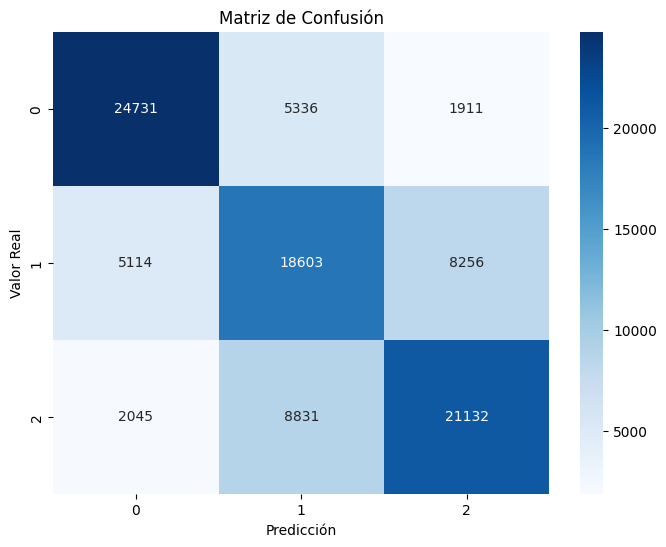

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

In [ ]:
#ROC-AUC multiclase (aunque es una métrica más favorable para modelos de clasificación binaria)
y_test_binarized_1 = label_binarize(y_test, classes=np.unique(y))
y_pred_proba_1 = model_1.predict_proba(X_test)
auc_score_1 = roc_auc_score(y_test_binarized_1, y_pred_proba_1, average='macro')
print("ROC-AUC Score (macro-average):", auc_score_1)

ROC-AUC Score (macro-average): 0.7538564283608297


En un caso multiclase como este, se evalúa la capacidad del modelo para predecir correctamente cada clase en comparación con las demás.

### Optimización 1: Feature importance

In [ ]:
feature_importances = model_1.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
importance_df

,Feature,Importance
12,popularity,0.389137
6,loudness,0.071356
0,duration_ms,0.064403
1,acousticness,0.059082
2,danceability,0.044487
7,speechiness,0.040880
8,tempo,0.039294
5,liveness,0.034308
4,instrumentalness,0.034136
9,valence,0.032941


In [ ]:
X_reduc = df[['duration_ms', 'acousticness', 'danceability', 'energy', 
              'loudness', 'speechiness', 'tempo', 'valence', 'popularity']]

In [ ]:
#Dividimos en conjuntos para entrenamiento y pruebas
X_train_reduc, X_test_reduc, y_train, y_test = train_test_split(X_reduc, y, train_size=0.2, random_state=42)

In [ ]:
print(X.shape)
print(X_train_reduc.shape)
print(X_test_reduc.shape)
print(y_train.shape)
print(y_test.shape)

(119948, 19)
(23989, 9)
(95959, 9)
(23989,)
(95959,)


In [ ]:
model_2 = DecisionTreeClassifier(random_state=42)

In [ ]:
#Entrenamiento
model_2.fit(X_train_reduc, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
#Evaluación
y_pred_2 = model_2.predict(X_test_reduc)
accuracy_2 = accuracy_score(y_test, y_pred_2)
precision_2 = precision_score(y_test, y_pred_2, average='macro')
recall_2 = recall_score(y_test, y_pred_2, average='macro')
f1_2 = f1_score(y_test, y_pred_2, average='macro')

In [ ]:
print("Accuracy del modelo Decision Tree:", accuracy_2)
print("Precisión (Precision):", precision_2)
print("Sensibilidad (Recall):", recall_2)
print("F1-Score:", f1_2)

Accuracy del modelo Decision Tree: 0.6668681416021426
Precisión (Precision): 0.6672386784520011
Sensibilidad (Recall): 0.6668658447942324
F1-Score: 0.6670374104319264


<mark>**Conclusión:**</mark> Haciendo una selección de variables (feature importance > 5) el modelo empeora ligeramente, lo que confirma que estas características tienen una importancia mínima en la predicción de la década.

### Optimización 2: SelectKBest

In [ ]:
k = 10
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

In [ ]:
print(f"\nCaracterísticas seleccionadas con SelectKBest (top {k}):")
print(selected_features)


Características seleccionadas con SelectKBest (top 10):
Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'loudness', 'popularity', 'explicit', 'energy_danceability_valence',
       'acoustic_intensity', 'valence_energy_dif'],
      dtype='object')


In [ ]:
X_train_k, X_test_k, y_train, y_test = train_test_split(X_new, y, train_size=0.2, random_state=42)

In [ ]:
print(X.shape)
print(X_train_k.shape)
print(X_test_k.shape)
print(y_train.shape)
print(y_test.shape)

(119948, 19)
(23989, 10)
(95959, 10)
(23989,)
(95959,)


In [ ]:
model_3 = DecisionTreeClassifier(random_state=42)

In [ ]:
#Entrenamiento
model_3.fit(X_train_k, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
#Evaluación
y_pred_3 = model_3.predict(X_test_k)
accuracy_3 = accuracy_score(y_test, y_pred_3)
precision_3 = precision_score(y_test, y_pred_3, average='macro')
recall_3 = recall_score(y_test, y_pred_3, average='macro')
f1_3 = f1_score(y_test, y_pred_3, average='macro')

In [ ]:
print("Accuracy del modelo Decision Tree:", accuracy_3)
print("Precisión (Precision):", precision_3)
print("Sensibilidad (Recall):", recall_3)
print("F1-Score:", f1_3)

Accuracy del modelo Decision Tree: 0.657624610510739
Precisión (Precision): 0.6568846755639125
Sensibilidad (Recall): 0.6576182967606056
F1-Score: 0.6572085397686579


<mark>**Conclusión:**</mark> La selección de las mejores características ha tenido un efecto positivo, pero el incremento es marginal. Esto podría significar que la selección de características ayuda a reducir un poco el ruido, pero no es suficiente para un aumento significativo en el rendimiento. Es posible que las características seleccionadas no estén capturando toda la complejidad necesaria para mejorar significativamente el modelo, o que el modelo de Decision Tree tenga limitaciones para manejar este tipo de problema.



### Optimización 3: Hiperparametrización

In [ ]:
#Configuración de hiperparámetros para DecisionTree
param_grid = {'max_depth': [5, 10, 15, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

In [ ]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_k, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
# Mostrar los mejores parámetros encontrados
grid_best_params = grid_search.best_params_
print("Mejores hiperparámetros:", grid_best_params)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
#Evaluación del modelo
best_model = grid_search.best_estimator_
y_pred_4 = best_model.predict(X_test_k)
accuracy_4 = accuracy_score(y_test, y_pred_4)
precision_4 = precision_score(y_test, y_pred_4, average='macro')
recall_4 = recall_score(y_test, y_pred_4, average='macro')
f1_4 = f1_score(y_test, y_pred_4, average='macro')

In [ ]:
print("Accuracy del modelo Decision Tree:", accuracy_4)
print("Precisión (Precision):", precision_4)
print("Sensibilidad (Recall):", recall_4)
print("F1-Score:", f1_4)

Accuracy del modelo Decision Tree: 0.7176710886941298
Precisión (Precision): 0.7277868400782933
Sensibilidad (Recall): 0.7176295657364764
F1-Score: 0.7175517957010252


<mark>**Conclusión:**</mark> La hiperparametrización ha mejorado el modelo de forma significativa, mostrando que ajustar la profundidad a 10, el mínimo de muestras por hoja a 2 y los nodos mínimos a 2 mejora la capacidad de generalización. No obstante, el rendimiento sigue siendo moderado y deberemos probar con otro modelos.

### Guardar modelo

In [45]:
import pickle

with open('basicmodel2.pkl', 'wb') as f:
    pickle.dump(model_2, f)